In [2]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch as ch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Gumbel
import math

import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import config

from delphi import train
from delphi.cifar_models import vgg11
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR
import delphi.utils.data_augmentation as da
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata
import pickle
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
BASE_STORE = '/home/pstefanou/cifar-10/resnet-18/base/'
BASE_CLASSIFIER_PATH = '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.latest'
LOGIT_BALL_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_10'
STANDARD_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_10'
DATA_PATH = '/home/pstefanou/data/'

# Experiment Hyperparameters

In [13]:
args = Parameters({ 
    'epochs': 150,
    'workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'accuracy': True,
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
    'custom_lr_multiplier': consts.COSINE, 
#     'step_lr': 2000000, 
#     'step_lr_gamma': 1.0,
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
    'logit_ball': 10,
    'trials': 5,
})


if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
print("args: ", args)

args:  {
  "epochs": 150,
  "workers": 8,
  "batch_size": 128,
  "lr": 0.1,
  "accuracy": true,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "save_ckpt_iters": 50,
  "should_save_ckpt": true,
  "log_iters": 1,
  "custom_lr_multiplier": "cosine",
  "validation_split": 0.8,
  "shuffle": true,
  "parallel": false,
  "num_samples": 1000,
  "logit_ball": 10,
  "trials": 5,
  "device": "cuda"
}


# Setup and Explore Dataset

In [14]:
ds = CIFAR(data_path='/home/pstefanou/')
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8)

Files already downloaded and verified
Files already downloaded and verified


label: deer


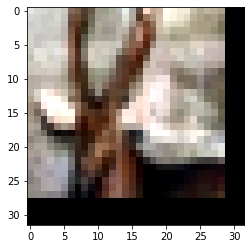

label: bird


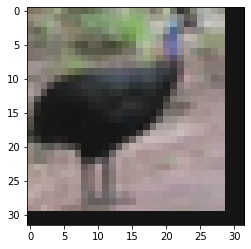

label: cat


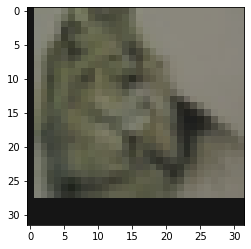

label: ship


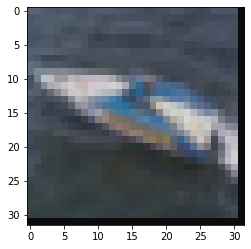

label: airplane


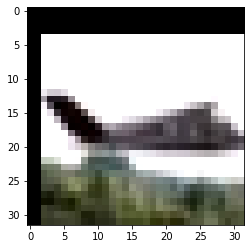

label: automobile


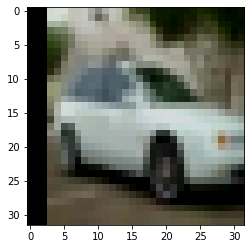

label: dog


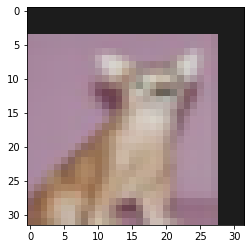

label: horse


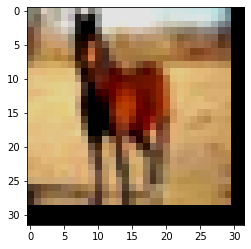

label: frog


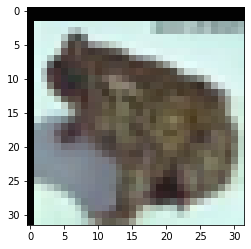

label: truck


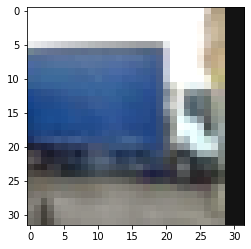

In [6]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Load in Base Classifier and Define Filtering Mechanism

In [15]:
base_classifier, base_sd = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
base_classifier = base_classifier.to(args.device)

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.latest' (epoch 150)


In [16]:
phi = oracle.LogitBallComplement(args.logit_ball)
gumbel = Gumbel(0, 1)

# Truncate Dataset 

In [17]:
class TruncatedCIFAR(Dataset):
    """
    Truncated CIFAR-10 dataset [Kri09]_.
    Original dataset has 50k training images and 10k testing images, with the
    following classes:
    * Airplane
    * Automobile
    * Bird
    * Cat
    * Deer
    * Dog
    * Frog
    * Horse
    * Ship
    * Truck
    .. [Kri09] Krizhevsky, A (2009). Learning Multiple Layers of Features
        from Tiny Images. Technical Report.
        
    Truncated dataset only includes images and labels from original dataset that fall within the truncation set.
    """
    def __init__(self, img, label, transform):
        """
        """
        self.img = img 
        self.label = label
        self.transform = transform

    def __getitem__(self, idx):
        """
        """
        x = self.img[idx]
        y = self.label[idx]
        # data augmentation
        if self.transform: 
            x = self.transform(x)
            
        return x, y
    
    def __len__(self): 
        return self.img.size(0)
    
TRUNC_TRAIN_TRANSFORMS = lambda size: transforms.Compose([
        transforms.ToPILImage(mode="RGB"),
        transforms.RandomCrop(size, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(.25, .25, .25),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
    ])

TRUNC_TEST_TRANSFORMS = lambda size: transforms.Compose([
    transforms.ToPILImage(mode="RGB"),
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.ToTensor()
])

In [18]:
# check if there exists a cifar 10 train truncated dataset already
if not os.path.isfile(DATA_PATH + 'trunc_train_logit_' + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle'):
    trunc_train_X, trunc_train_y = Tensor([]), Tensor([])
    # unseen test data
    trunc_test_X, trunc_test_y = Tensor([]), Tensor([])
    for inp, targ in train_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_train_X, trunc_train_y = ch.cat([trunc_train_X, inp[indices].cpu()]), ch.cat([trunc_train_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("train alpha: ", trunc_train_X.size(0) / len(train_loader.dataset))
    trunc_train_loader = DataLoader(TruncatedCIFAR(trunc_train_X, trunc_train_y.long(), transform= TRUNC_TRAIN_TRANSFORMS(32)), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # train loader
    with open(DATA_PATH + 'trunc_train_logit_' + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_train_loader, f)
else:  
    trunc_train_loader = pd.read_pickle(DATA_PATH + 'trunc_train_logit_' + str(args.logit_ball) + '.pickle')
trunc_train_loader

train alpha:  0.68172


In [19]:
# check if there exists a cifar 10 valdation and test truncated dataset
if not os.path.isfile(DATA_PATH + 'trunc_val_logit_' + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle'):
    trunc_val_X, trunc_val_y = Tensor([]), Tensor([]) 

    for inp, targ in val_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_val_X, trunc_val_y = ch.cat([trunc_val_X, inp[indices].cpu()]), ch.cat([trunc_val_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("val alpha: ", trunc_val_X.size(0) / len(val_loader.dataset))
    trunc_val_loader = DataLoader(TruncatedCIFAR(trunc_val_X, trunc_val_y.long(), transform=TRUNC_TEST_TRANSFORMS(32)), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)
    # truncated test set (unseen data that the model has not been tested on)
    trunc_test_loader = DataLoader(TruncatedCIFAR(trunc_test_X, trunc_test_y.long(), transform=TRUNC_TEST_TRANSFORMS(32)), 
                             num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # validation loader
    with open(DATA_PATH + 'trunc_val_logit_' + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_val_loader, f)

    # test loader
    with open(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_test_loader, f)
else: 
    trunc_val_loader = pd.read_pickle(DATA_PATH + 'trunc_val_logit_'+ str(args.logit_ball) + '.pickle')
    trunc_test_loader = pd.read_pickle(DATA_PATH + 'trunc_test_logit_' + str(args.logit_ball) + '.pickle')
trunc_val_loader, trunc_test_loader

val alpha:  0.6591


(<torch.utils.data.dataloader.DataLoader at 0x7f5afbc56e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5afbc567f0>)

In [20]:
print("alpha train: ", len(trunc_train_loader.dataset) / len(train_loader.dataset))
print("alpha train: ", len(trunc_val_loader.dataset) / len(val_loader.dataset))

alpha train:  0.68172
alpha train:  0.6591


# Setup Store and Train Model

In [21]:
standard_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
# logging store
out_store = store.Store(STANDARD_CLASSIFIER)
setup_store_with_metadata(args, out_store)
args.__setattr__('custom_criterion', None)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_10/4b94a97b-0c29-4592-a372-836944d2eb70


# Start by Training Standard Classifier

In [22]:
# train
ch.manual_seed(0)
final_model = train.train_model(args, standard_model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [23]:
path = '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5'
# reader = CollectionReader(STANDARD_CLASSIFIER)
reader = CollectionReader(path)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 2/2 [00:00<00:00, 110.83it/s]

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,34.997936,1.753397,25.824753,2.051185,27.317727,712df46f-415c-4425-9691-bdd95860a8aa
1,2,44.614117,1.542356,37.865940,1.666547,54.677985,712df46f-415c-4425-9691-bdd95860a8aa
2,3,48.452332,1.451098,47.052292,1.457411,81.909324,712df46f-415c-4425-9691-bdd95860a8aa
3,4,55.189850,1.296427,54.875832,1.248126,109.034021,712df46f-415c-4425-9691-bdd95860a8aa
4,5,66.704498,0.959405,61.916008,1.074829,136.497644,712df46f-415c-4425-9691-bdd95860a8aa


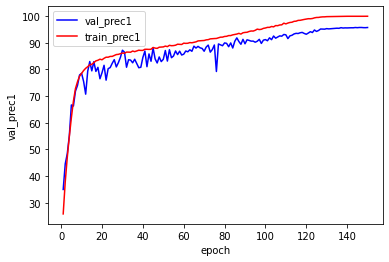

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

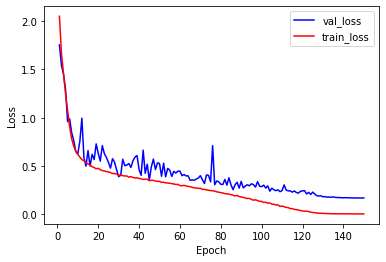

In [25]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
ax.set(xlabel='Epoch', ylabel='Loss')

In [27]:
# check accuracy
out_store = store.Store(STANDARD_CLASSIFIER)

# evaluate model on train, validation, and unseen datasets
test_set_results = train.eval_model(args, standard_model, trunc_test_loader, out_store)
print("test set results: ", test_set_results)
train_set_results = train.eval_model(args, standard_model, trunc_train_loader, out_store)
print("train set results: ", train_set_results)
val_set_results = train.eval_model(args, standard_model, trunc_val_loader, out_store) 
print("val set results: ", val_set_results)

out_store.close()

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_10/3173e8ba-fe5b-4f8a-bc17-a63162d3244d


  0%|          | 0/151 [00:00<?, ?it/s]

test set results:  {'test_prec1': tensor(92.9152, device='cuda:0'), 'test_loss': 0.2629543676380908, 'time': 3.3963303565979004}


  0%|          | 0/267 [00:00<?, ?it/s]

train set results:  {'test_prec1': tensor(99.9795, device='cuda:0'), 'test_loss': 0.0017541877034934533, 'time': 5.693283319473267}


  0%|          | 0/52 [00:00<?, ?it/s]

val set results:  {'test_prec1': tensor(96.0704, device='cuda:0'), 'test_loss': 0.14801723114324347, 'time': 1.5254392623901367}


In [31]:
# logging store
out_store = store.Store(LOGIT_BALL_CLASSIFIER)
setup_store_with_metadata(args, out_store)
# model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
# load in previously trained classifer to run truncated gradient against it
delphi_ =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/4b94a97b-0c29-4592-a372-836944d2eb70/checkpoint.pt.latest')
# set oracle
args.__setattr__('phi', phi)
# set gradient 
args.__setattr__('custom_criterion', grad.TruncatedCE.apply)
config.args = args

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_10/9f35ae1f-9a40-4f81-8deb-74ac4ae93477
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_10/4b94a97b-0c29-4592-a372-836944d2eb70/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_10/4b94a97b-0c29-4592-a372-836944d2eb70/checkpoint.pt.latest' (epoch 150)


# TruncatedCE with Logit Ball Oracle

In [33]:
# train
ch.manual_seed(0)
final_model = train.train_model(args, delphi_[0], (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
path = '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5/'
# reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
reader = CollectionReader(path)
metadata = reader.df('metadata')
trunc_logs = reader.df('logs')
reader.close()
logs.head()

# Accuracy and Loss Curves

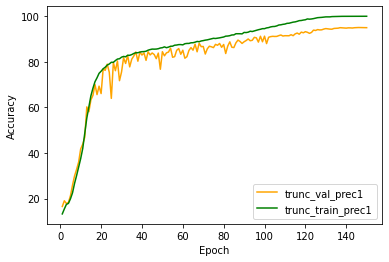

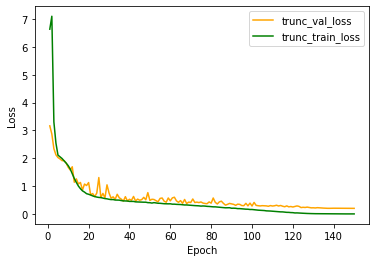

In [229]:
def trunc_plot(logs):
    sns.lineplot(data=logs, x='epoch', y='val_prec1', label='trunc_val_prec1', color='orange')
    ax = sns.lineplot(data=logs, x='epoch', y='train_prec1', label='trunc_train_prec1', color='g')
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    plt.show()

    sns.lineplot(data=logs, x='epoch', y='val_loss', label='trunc_val_loss', color='orange')
    ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='trunc_train_loss', color='g')
    ax.set(xlabel='Epoch', ylabel='Loss')
trunc_plot(trunc_logs)

# Train Standard Classifier on Resnet18

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5/712df46f-415c-4425-9691-bdd95860a8aa


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 40.60it/s]

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,34.997936,1.753397,25.824753,2.051185,27.317727,712df46f-415c-4425-9691-bdd95860a8aa
1,2,44.614117,1.542356,37.865940,1.666547,54.677985,712df46f-415c-4425-9691-bdd95860a8aa
2,3,48.452332,1.451098,47.052292,1.457411,81.909324,712df46f-415c-4425-9691-bdd95860a8aa
3,4,55.189850,1.296427,54.875832,1.248126,109.034021,712df46f-415c-4425-9691-bdd95860a8aa
4,5,66.704498,0.959405,61.916008,1.074829,136.497644,712df46f-415c-4425-9691-bdd95860a8aa


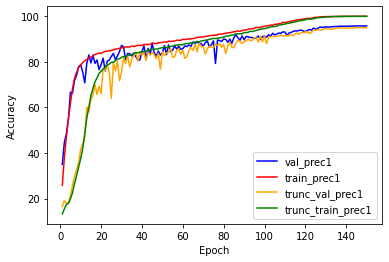

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

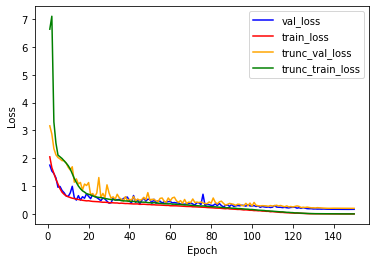

In [23]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='trunc_val_prec1', color='orange')
ax = sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='trunc_train_prec1', color='g')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', label='trunc_val_loss', color='orange')
ax = sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='trunc_train_loss', color='g')
ax.set(xlabel='Epoch', ylabel='Loss')

In [ ]:
# set oracle
args.__setattr__('phi', phi)

ch.manual_seed(0)
# perform 10 trials of exp
for i in range(args.trials):
    
    # logging store
    out_store = store.Store(LOGIT_BALL_CLASSIFIER)
    setup_store_with_metadata(args, out_store)
    trunc_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)


    # set gradient 
    args.__setattr__('custom_criterion', grad.TruncatedCE.apply)
    config.args = args
    
    # train model
    train.train_model(args, trunc_model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)

    # evaluate model on train, validation, and unseen datasets
    train.eval_model(args, trunc_model, trunc_test_loader, out_store)
    train.eval_model(args, trunc_model, trunc_train_loader, out_store)
    train.eval_model(args, trunc_model, trunc_val_loader, out_store)    
    
    # close store
    out_store.close()
    
    # logging store
    out_store = store.Store(STANDARD_CLASSIFIER)
    setup_store_with_metadata(args, out_store)
    standard_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)

    args.__setattr__('custom_criterion', None)
    config.args = args
    
    # train model
    train.train_model(args, standard_model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
    
    # evaluate model on train, validation, and unseen datasets
    train.eval_model(args, standard_model, trunc_test_loader, out_store)
    train.eval_model(args, standard_model, trunc_train_loader, out_store)
    train.eval_model(args, standard_model, trunc_val_loader, out_store) 
    
    # close store
    out_store.close()

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5_5_Trials/1b1dc8a5-4a8c-4507-be2f-282272914b05


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5_5_Trials/06ea55b6-fdbe-4439-add0-480facfd7fd3


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5_5_Trials/b230765e-dd54-42c1-8572-86515dcb9d1d


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5_5_Trials/4218741f-fbaa-43ec-8ed7-4ef645f7d582


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5_5_Trials/1a01a2c8-30f2-4619-beef-d6a3d5b69399


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5_5_Trials/69e0ae6b-3e30-4c75-8557-199f6c96a263


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/387 [00:00<?, ?it/s]

In [56]:
r = CollectionReader('/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5_10_Trials/')
# r_ = CollectionReader('/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5_10_Trials/')

r.df('eval')

100%|██████████| 1/1 [00:00<00:00, 62.28it/s]


,test_prec1,test_loss,time,exp_id
0,12.210797,8.660437,0.780003,dc3566a3-a599-4a58-b143-38a3fb896649
1,14.363012,6.911546,7.988960,dc3566a3-a599-4a58-b143-38a3fb896649
2,15.435411,7.342247,2.063115,dc3566a3-a599-4a58-b143-38a3fb896649


# Load Trained Models into Notebook

In [9]:
base = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
delphi_ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=LOGIT_BALL_CLASSIFIER + '/664ec3fc-d3b5-426a-8b29-fac034a3e617/checkpoint.pt.latest')
standard =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/712df46f-415c-4425-9691-bdd95860a8aa/checkpoint.pt.latest')

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454/checkpoint.pt.latest' (epoch 150)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5/664ec3fc-d3b5-426a-8b29-fac034a3e617/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5/664ec3fc-d3b5-426a-8b29-fac034a3e617/checkpoint.pt.latest' (epoch 150)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5/712df46f-415c-4425-9691-bdd95860a8aa/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5/712df46f-415c-4425-9691-bdd95860a8aa/checkpoint.pt.latest' (epoch 150)


# Test Accuracy

In [10]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/logit_ball_complement_logit_7.5/17986d8a-9bf4-4010-885a-b60809d35b49


In [11]:
delphi_test_results = train.eval_model(args, delphi_[0], trunc_test_loader, delphi_store)
print("delphi test results: ", delphi_test_results)

delphi_train_results = train.eval_model(args, delphi_[0], trunc_train_loader, delphi_store)
print("delphi train results: ", delphi_train_results)

delphi_val_results = train.eval_model(args, delphi_[0], trunc_val_loader, delphi_store)
print("delphi val results: ", delphi_val_results)
delphi_store.close()

  0%|          | 0/7 [00:00<?, ?it/s]

delphi test results:  {'test_prec1': tensor(82.1337, device='cuda:0'), 'test_loss': 0.7985180265492829, 'time': 0.7745773792266846}


  0%|          | 0/387 [00:00<?, ?it/s]

delphi train results:  {'test_prec1': tensor(99.9677, device='cuda:0'), 'test_loss': 0.002157983849016984, 'time': 7.8071253299713135}


  0%|          | 0/76 [00:00<?, ?it/s]

delphi val results:  {'test_prec1': tensor(94.9340, device='cuda:0'), 'test_loss': 0.2027447234148877, 'time': 1.9056134223937988}


In [12]:
base_store = store.Store(BASE_STORE)

Logging in: /home/pstefanou/cifar-10/resnet-18/base/d39177ae-0800-4e96-8bc3-3aef397e19be


In [13]:
base_test_results = train.eval_model(args, base[0], trunc_test_loader, base_store)
print("base test results: ", base_test_results)

base_train_results = train.eval_model(args, base[0], trunc_train_loader, base_store)
print("base train results: ", base_train_results)

base_val_results = train.eval_model(args, base[0], trunc_val_loader, base_store)
print("base val results: ", base_val_results)
base_store.close()

  0%|          | 0/7 [00:00<?, ?it/s]

base test results:  {'test_prec1': tensor(91.6452, device='cuda:0'), 'test_loss': 0.2694118710158149, 'time': 0.6086664199829102}


  0%|          | 0/387 [00:00<?, ?it/s]

base train results:  {'test_prec1': tensor(99.3640, device='cuda:0'), 'test_loss': 0.021101607923942542, 'time': 7.8513312339782715}


  0%|          | 0/76 [00:00<?, ?it/s]

base val results:  {'test_prec1': tensor(95.0991, device='cuda:0'), 'test_loss': 0.18445466792735982, 'time': 1.9070582389831543}


In [14]:
standard_store = store.Store(STANDARD_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_logit_ball_complement_logit_7.5/b4bdbfc2-a0d2-4b42-8d61-0afcc5400b38


In [15]:
standard_test_results = train.eval_model(args, standard[0], trunc_test_loader, standard_store)
print("standard test results: ", standard_test_results)

standard_train_results = train.eval_model(args, standard[0], trunc_train_loader, standard_store)
print("standard train results: ", standard_train_results)

standard_val_results = train.eval_model(args, standard[0], trunc_val_loader, standard_store)
print("standard val results: ", standard_val_results)
standard_store.close()

  0%|          | 0/7 [00:00<?, ?it/s]

standard test results:  {'test_prec1': tensor(85.2185, device='cuda:0'), 'test_loss': 0.5897831105241662, 'time': 0.6278173923492432}


  0%|          | 0/387 [00:00<?, ?it/s]

standard train results:  {'test_prec1': tensor(99.9879, device='cuda:0'), 'test_loss': 0.0017635373544597963, 'time': 7.855552911758423}


  0%|          | 0/76 [00:00<?, ?it/s]

standard val results:  {'test_prec1': tensor(95.7491, device='cuda:0'), 'test_loss': 0.16821936668318457, 'time': 1.9085979461669922}
